In [200]:
import numpy as np
import random as rnd
import time as tm
from matplotlib import pyplot as plt
%matplotlib inline

In [201]:
Z = np.loadtxt( "data" )
np.random.shuffle(Z)
d = Z.shape[1]-1
n = Z.shape[0]

extra_1 = np.ones((n,1))

Z1 = np.append(Z,extra_1,axis = 1)
print(Z1)
y = Z1[:,0]
X = Z1[:,1:]
lim = int(0.8*n)
d = d+1
train_x = Z[:lim,1:]
train_y = Z[:lim,0]
test_x = Z[lim:,1:]
test_y = Z[lim:,0]

[[ 1.        0.524383  1.       ...  0.        0.047977  1.      ]
 [-1.        0.369324  0.       ...  0.       -0.07759   1.      ]
 [-1.        0.255859  0.       ...  0.        0.432525  1.      ]
 ...
 [-1.        0.184265  0.       ...  1.        0.054889  1.      ]
 [-1.        0.233307  0.       ...  0.       -0.054833  1.      ]
 [-1.        0.492432  0.       ...  0.       -0.266911  1.      ]]


In [202]:
# Get the CSVM objective value in order to plot convergence curves
def getCSVMObjVal( theta ):
    
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( theta ) ), y ), 0 )
    #print("Hinge loss = "+str(hingeLoss))
    return 0.5 * theta.dot( theta ) + C * np.dot(hingeLoss,hingeLoss.T)

In [203]:
def getCyclicCoord( currentCoord ):
    if currentCoord >= lim-1 or currentCoord < 0:
        return 0
    else:
        return currentCoord + 1

In [204]:
def getRandCoord( currentCoord ):
    return rnd.randint( 0, lim-1 )

In [205]:
def getRandpermCoord( currentCoord ):
    global randperm, randpermInner
    if randpermInner >= lim-1 or randpermInner < 0 or currentCoord < 0:
        randpermInner = 0
        randperm = np.random.permutation( y.size )
        return randperm[randpermInner]
    else:
        randpermInner = randpermInner + 1
        return randperm[randpermInner]

In [206]:
def doSDCM( getCoordFunc, init, horizon = 10 ):
    primalObjValSeries = np.zeros( (horizon,) )
    dualObjValSeries = np.zeros( (horizon,) )
    timeSeries = np.zeros( (horizon,) )
    totTime = 0
    
    # Initialize model as well as some bookkeeping variables
    alpha = init
    alphay = np.multiply( alpha, y )
    # Initialize the model vector using the equations relating primal and dual variables
    w = X.T.dot( alphay )
    # Recall that we are imagining here that the data points have one extra dimension of ones
    # This extra dimension plays the role of the bias in this case
   
    # Calculate squared norms taking care that we are appending an extra dimension of ones
    normSq = np.square( np.linalg.norm( X, axis = 1 ) )
    # We have not made any choice of coordinate yet
    i = -1
    
    for t in range( horizon ):
        tic = tm.perf_counter()
        
        i = getCoordFunc( i )
        x = X[i,:]
        
        # Find the unconstrained new optimal value of alpha_i
        newAlphai = (1 - y[i] * (x.dot(w)) + alpha[i] * normSq[i]) / (normSq[i] + 0.5/C)
        # Make sure that the constraints are satisfied
        if newAlphai < 0:
            newAlphai = 0
        
        # Update the model vector and bias values
        # Takes only O(d) time to do so :)
        w = w + (newAlphai - alpha[i]) * y[i] * x
        alpha[i] = newAlphai

        toc = tm.perf_counter()
        totTime = totTime + (toc - tic)
        if t%10000 ==0:
            print(t)
        primalObjValSeries[t] = getCSVMObjVal( w )
        #dualObjValSeries[t] = getCSVMObjValDual( alpha, w, b )
        timeSeries[t] = totTime
        
    print( "nSV = ", np.sum( alpha > C/100 ), " out of ", y.size, "data points" )    
    return (w, primalObjValSeries, dualObjValSeries, timeSeries)


In [210]:
# Final values of w and b

randperm = np.random.permutation( y.size )
randpermInner = -1
C = 1
eta = 0.01
y = Z1[:,0]
X = Z1[:,1:]
(theta_SDCM, primal_SDCM, dual_SDCM, time_SDCM) = doSDCM( getRandCoord, C * np.zeros( (y.size,) ), horizon = 300000 )


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
nSV =  8952  out of  20000 data points


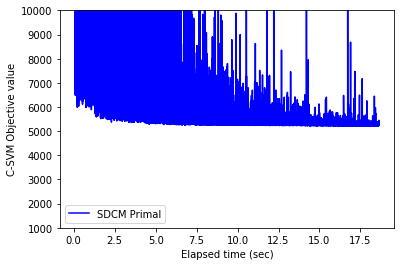

In [218]:
plt.plot( time_SDCM, primal_SDCM, color = 'b', linestyle = '-', label = "SDCM Primal" )
#plt.plot( time_SDCM, dual_SDCM, color = 'b', linestyle = ':', label = "SDCM Dual" )
#plt.plot( time_SGD, obj_SGD, color = 'r', linestyle = '-', label = "SGD" )
plt.legend()
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
plt.ylim( 10**3, 10*10**3)
plt.show()

In [212]:
primal_SDCM[-1]

5296.815415192437

In [220]:
theta_SDCM

array([-0.8446657 ,  0.22054605, -0.06297124,  0.53274281,  0.65550638,
        0.21306386, -3.43806178,  0.47401096,  0.20474156,  1.2933272 ,
       -1.24060256, -0.09931551,  0.47545651,  0.29929617, -0.15468443,
        1.08613053,  0.3753558 ,  0.15995374,  0.18520181, -0.4046673 ,
       -1.05969057])

In [221]:
primal_SDCM

array([10632.29715298,  8389.75884964,  7743.20469779, ...,
        5427.95047554,  5315.63113218,  5296.81541519])

In [224]:
import pickle

In [225]:
file = open("obj_sdcm","wb")

In [226]:
pickle.dump(primal_SDCM,file)

In [228]:
file.close()

In [229]:
file = open("sdcm_time","wb")

In [230]:
pickle.dump(time_SDCM,file)

In [231]:
file.close()

In [233]:
time_SDCM

array([ 0.06565339,  0.06568926,  0.06572551, ..., 18.64310674,
       18.6431883 , 18.64324871])